In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# setup
N = 20
ndim = 2

# Dynamics
A = np.array([[1.0, 1.0],[0.0, 0.95]])
b = np.array([[0], [0.1]])

# Trajectory condition
x_i = np.array([0,0])
x_f = np.array([10.0, 0])

In [3]:
# Method 01
# By keeping operations |·|, max, min implicit and making CVXPY convert it to LP for you.
x = cp.Variable(shape = (ndim, N+1))
u = cp.Variable(shape = (1, N))

# Define objective function
objective = cp.Minimize(cp.sum(cp.maximum(cp.abs(u), 2 * cp.abs(u) - 1)))

# Define constraints
constraints = [
    x[:,0] == x_i,
    x[:,1:] == A @ x[:,:N] + b @ u,
    x[:,-1] == x_f
]

prob = cp.Problem(objective, constraints)
prob.solve()

# solution
status = prob.status
x_optimal = x.value
p_optimal = prob.value
u_optimal = u.value

status: optimal
optimal value : 15.91


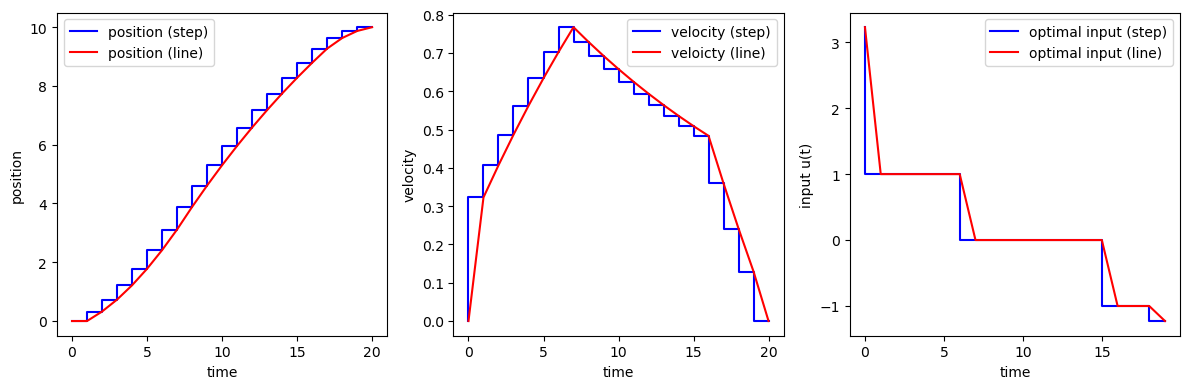

In [4]:
print("status: {}".format(status))
print("optimal value : {:.2f}".format(p_optimal))

fig, axes = plt.subplots(1,3, figsize = (12,4))

axes = axes.ravel()

# state : position
axes[0].step(np.array([i for i in range(0,N+1)]), x_optimal[0,:].reshape(-1,), c = 'b', label = "position (step)")
axes[0].plot(np.array([i for i in range(0,N+1)]), x_optimal[0,:].reshape(-1,), c = 'r', label = "position (line)")
axes[0].set_xlabel("time")
axes[0].set_ylabel("position")
axes[0].legend()

# velocity
axes[1].step(np.array([i for i in range(0,N+1)]), x_optimal[1,:].reshape(-1,), c = 'b', label = "velocity (step)")
axes[1].plot(np.array([i for i in range(0,N+1)]), x_optimal[1,:].reshape(-1,), c = 'r', label = "veloicty (line)")
axes[1].set_xlabel("time")
axes[1].set_ylabel("velocity")
axes[1].legend()

# input
axes[2].step(np.array([i for i in range(0,N)]), u_optimal.reshape(-1,), c = 'b', label = "optimal input (step)")
axes[2].plot(np.array([i for i in range(0,N)]), u_optimal.reshape(-1,), c = 'r', label = "optimal input (line)")
axes[2].set_xlabel("time")
axes[2].set_ylabel("input u(t)")
axes[2].legend()

fig.tight_layout()

In [59]:
# Method 02
# By applying directly the LP formulation you obtained in point 1
t = cp.Variable(shape = (N,1))
mu = cp.Variable(shape = (N,1))
u = cp.Variable(shape = (N,1))

# Define objective function
objective = cp.Minimize(cp.sum(t))

At = np.concatenate([(np.linalg.matrix_power(A, N - i) @ b).reshape(-1,1) for i in range(1, N+1)], axis = 1)
bt = x_f - np.linalg.matrix_power(A,N) @ x_i

# Define constraints
constraints = [
    (-1) * u <= mu,
    u <= mu,
    mu <= t,
    2 * mu - 1 <= t,
    At * u == bt.reshape(-1,1)
]

prob = cp.Problem(objective, constraints)
prob.solve()

# solution
status = prob.status
p_optimal = prob.value
t_optimal = t.value
mu_optimal = mu.value
u_optimal = u.value

# compute x_optimal
x_optimal = np.zeros((N+1, 2))
x_optimal[0,:] = x_i

for i in range(1,N+1):
    x_optimal[i,:] = A @ x_optimal[i-1,:] + b.reshape(-1,1) @ u_optimal[i-1]

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 24 times so far.

  warnings.warn(msg, UserWarning)


status: optimal
optimal value : 15.91


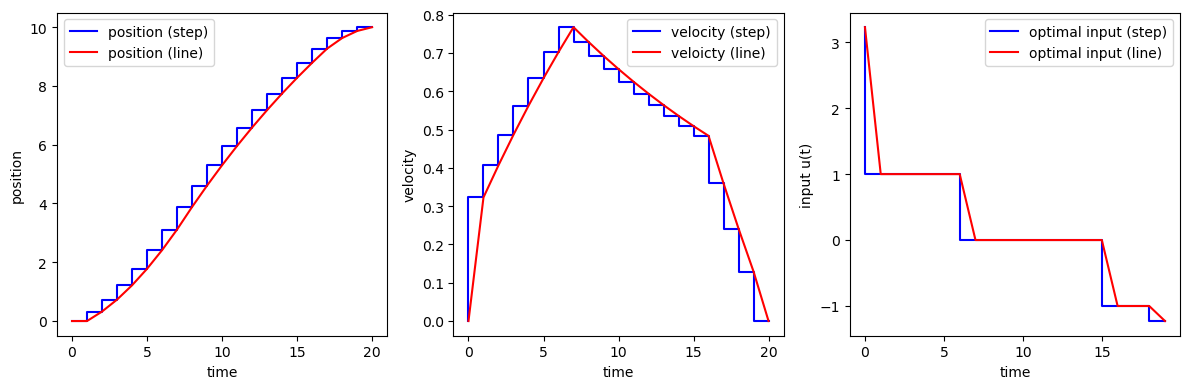

In [61]:
print("status: {}".format(status))
print("optimal value : {:.2f}".format(p_optimal))

fig, axes = plt.subplots(1,3, figsize = (12,4))

axes = axes.ravel()

# state : position
axes[0].step(np.array([i for i in range(0,N+1)]), x_optimal[:,0].reshape(-1,), c = 'b', label = "position (step)")
axes[0].plot(np.array([i for i in range(0,N+1)]), x_optimal[:,0].reshape(-1,), c = 'r', label = "position (line)")
axes[0].set_xlabel("time")
axes[0].set_ylabel("position")
axes[0].legend()

# velocity
axes[1].step(np.array([i for i in range(0,N+1)]), x_optimal[:,1].reshape(-1,), c = 'b', label = "velocity (step)")
axes[1].plot(np.array([i for i in range(0,N+1)]), x_optimal[:,1].reshape(-1,), c = 'r', label = "veloicty (line)")
axes[1].set_xlabel("time")
axes[1].set_ylabel("velocity")
axes[1].legend()

# input
axes[2].step(np.array([i for i in range(0,N)]), u_optimal.reshape(-1,), c = 'b', label = "optimal input (step)")
axes[2].plot(np.array([i for i in range(0,N)]), u_optimal.reshape(-1,), c = 'r', label = "optimal input (line)")
axes[2].set_xlabel("time")
axes[2].set_ylabel("input u(t)")
axes[2].legend()

fig.tight_layout()